# Initialization

In [6]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

In [7]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [8]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Libraries

In [9]:
def dP(PS):    
    S = PS.shape
    P = 1e5 * np.moveaxis(np.tile(hyai,(S[0],S[1],S[2],1)),3,1) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * np.moveaxis(np.tile(hybi,(S[0],S[1],S[2],1)),3,1)
    return P[:, 1:]-P[:, :-1]

In [10]:
# Moist thermo library in numpy
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

    return Rv*p*qv/(R*esat(T))

def RHsurf(T,qv,P0,PS):
    R = 287
    Rv = 461
    
    return Rv*PS*qv/(R*esat(T))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)
    
    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

In [11]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

In [12]:
def CRH(inp,input_sub,input_div):

    qv0 = inp[:,:30]*input_div[:30]+input_sub[:30]
    T = inp[:,30:60]*input_div[30:60]+input_sub[30:60]
    ps = inp[:,60]*input_div[60]+input_sub[60]

    dP0 = dP(ps)
    qsat0 = qsat(T,P0,ps,hyam,hybm)

    return np.sum(qv0*dP0,axis=1)/np.sum(qsat0*dP0,axis=1)

In [13]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            if np.sum(w)>0: Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)
            else: Ym[ibin-1] = np.nan; Ystd[ibin-1] = np.nan;

        edge_left = edge
    
    return Ym,Ystd

# Load data

In [14]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
# datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                           decode_times=False)
datam4K = xr.open_mfdataset(path+'0001-01-05-00000.nc',\
                          decode_times=False)

In [15]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
# datap4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
datap4K = xr.open_mfdataset(path+'0001-01-05-00000.nc',\
                           decode_times=False)

In [16]:
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.'
# dataref = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
dataref = xr.open_mfdataset(path+'0001-01-05-00000.nc',\
                           decode_times=False)

# Check Ankitesh's discrete and continuous tropopause pressure

## Functions developed by Ankitesh

In [17]:
def levTildeDiscrete(X,lev,inp_sub,inp_div,batch_size=1024,interm_dim_size=40):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:100] #batchx30
    X_temperature_denomalized = X_denormalized[:,30:100]
    
    lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denomalized[:,3:],axis=1)+3
#     imin = np.argwhere(np.diff(np.sign(X_temperature+0.10),axis=1))
#     print(imin)
#     print(imin[0,0].shape)
#     stop
    lev_roof = np.array(lev[imin])
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30

    
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,100:104]))
    
    return  X_result, lev_tilde, lev_roof

In [18]:
def levTildeConti(X,lev,inp_sub,inp_div,batch_size=1024,interm_dim_size=40,Tnot=5):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denormalized = X_denormalized[:,30:60]
    lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denormalized[:,3:],axis=1)+3 #take one below this and the next one
    lev1 = np.array(lev[imin-1]) #batch_size dim
    lev2 = np.array(lev[imin+1])
    T1 = np.take_along_axis( X_temperature_denormalized, (imin-1).reshape(-1,1),axis=1).flatten() ## batch_size
    T2 = np.take_along_axis( X_temperature_denormalized, (imin+1).reshape(-1,1),axis=1).flatten() ## batch_size    
    deltaT = T2-T1
    alpha = (1.0/2)*(2 - np.exp(-1*np.abs(deltaT/Tnot)))
    #alpha = np.maximum(0,np.minimum(1,alpha))
    lev_roof = alpha*lev1 + (1-alpha)*lev2
    
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))
    
    return  X_result, lev_tilde, lev_roof,alpha

## Transform data into right format

In [19]:
dataref.TAP.shape

(48, 30, 64, 128)

In [20]:
X = np.moveaxis(dataref.TAP.values,0,1)

In [21]:
X.shape

(30, 48, 64, 128)

In [22]:
X0 = np.reshape(X,(30,48*64*128))

In [23]:
X0.shape

(30, 393216)

In [24]:
X = np.transpose(
    np.concatenate((np.reshape(np.moveaxis(dataref.QAP.values,0,1),(30,48*64*128)),
                    np.reshape(np.moveaxis(dataref.TAP.values,0,1),(30,48*64*128))),axis=0)
)

In [25]:
X_result, lev_tilde, lev_roof = levTildeDiscrete(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40)

In [26]:
lev_roof.shape

(393216,)

In [27]:
lev_roof_0 = np.reshape(lev_roof,(48,64,128))

Text(0, 0.5, 'Mean Lev roof [hPa]')

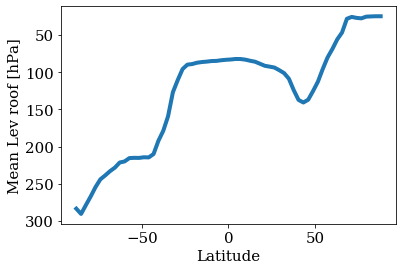

In [28]:
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [29]:
X_result, lev_tilde, lev_roof = levTildeConti(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40,Tnot=5)

ValueError: too many values to unpack (expected 3)

In [ ]:
lev_roof_0 = np.reshape(lev_roof,(48,64,128))

In [ ]:
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [287]:
def data2levroof(dataset,option,Tnot=5):
    
    S = dataset.QAP.shape
    X = np.transpose(
        np.concatenate((np.reshape(np.moveaxis(dataset.QAP.values,0,1),(30,S[0]*S[2]*S[3])),
                        np.reshape(np.moveaxis(dataset.TAP.values,0,1),(30,S[0]*S[2]*S[3]))),axis=0)
    )
    
    if option=='discrete':
        X_result, lev_tilde, lev_roof = \
        levTildeDiscrete(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40)
    elif option=='continuous':
        X_result, lev_tilde, lev_roof,alpha = \
        levTildeConti(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40,Tnot=Tnot)
        
    return np.reshape(lev_roof,(S[0],S[2],S[3])),np.reshape(alpha,(S[0],S[2],S[3]))

In [220]:
T = dataref.TAP.values

In [221]:
T.shape

(48, 30, 64, 128)

In [248]:
D = np.sign(np.diff(T,axis=1))
#imin = np.argwhere(D,axis=1)

In [249]:
D.shape

(48, 29, 64, 128)

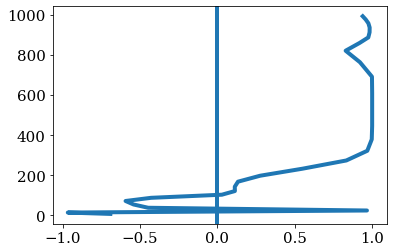

In [250]:
plt.plot(np.mean(D,axis=(0,2,3)),dataref.lev[1:])
plt.axvline(x=0)

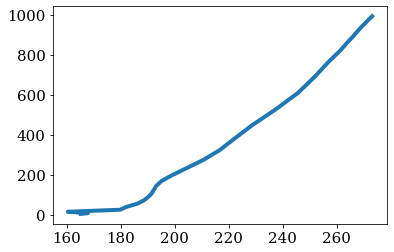

In [255]:
plt.plot(T[1,:,-2,5],dataref.lev)


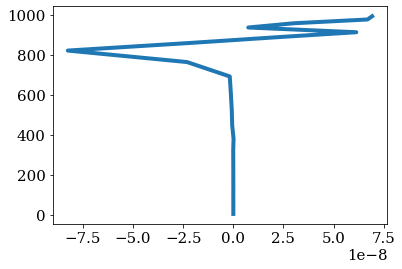

In [259]:
plt.plot(dataref.PHQ.values[1,:,-2,4],dataref.lev)

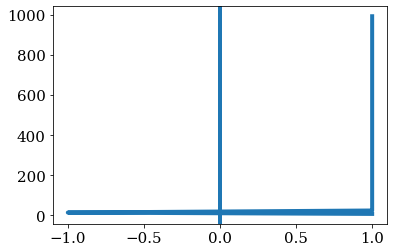

In [252]:
plt.plot(D[1,:,-2,5],dataref.lev[1:])
plt.axvline(x=0)

In [241]:
48*29*64*128

11403264

In [239]:
imin.shape

(11403264, 4)

In [240]:
imin[:,0]

array([ 0,  0,  0, ..., 47, 47, 47])

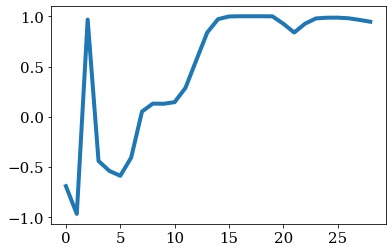

In [234]:
plt.plot(np.mean(imin,axis=(0,2,3)))

In [232]:
np.sum(imin==-1)/np.sum(imin**0)

0.2586944404689745

In [263]:
lev_roof_0 = data2levroof(dataref,'discrete')
lev_roof_m4 = data2levroof(datam4K,'discrete')
lev_roof_p4 = data2levroof(datap4K,'discrete')

Text(0, 0.5, 'Mean Lev roof [hPa]')

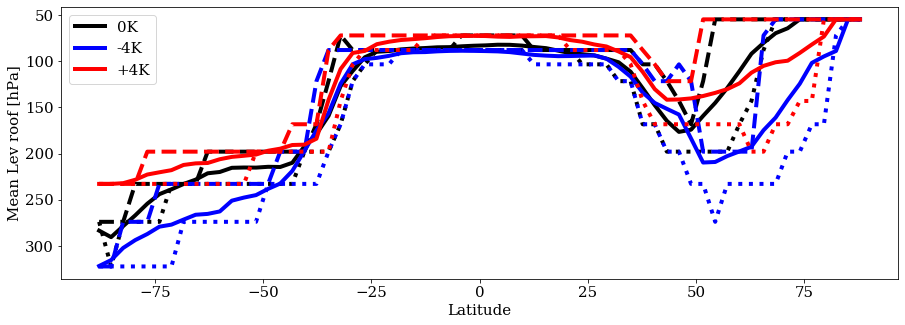

In [264]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [288]:
lev_roof_0,alpha_0 = data2levroof(dataref,'continuous',Tnot=5)
lev_roof_m4,alpha_m4 = data2levroof(datam4K,'continuous',Tnot=5)
lev_roof_p4,alpha_p4 = data2levroof(datap4K,'continuous',Tnot=5)

(array([57825., 58227., 48759., 40586., 36273., 27552., 18668., 12176.,
        11639., 81511.]),
 array([0.50000155, 0.5498187 , 0.5996359 , 0.64945304, 0.6992702 ,
        0.74908733, 0.79890454, 0.8487217 , 0.8985388 , 0.94835603,
        0.9981732 ], dtype=float32),
 <a list of 10 Patch objects>)

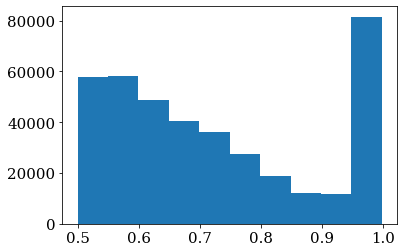

In [289]:
plt.hist(alpha_0.flatten())

In [281]:
dataref.lev[5]

<xarray.DataArray 'lev' ()>
array(54.59548)
Coordinates:
    lev      float64 54.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

Text(0, 0.5, 'Mean Lev roof [hPa]')

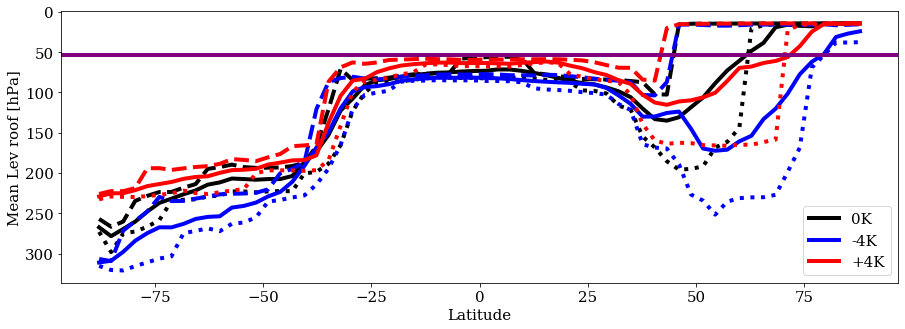

In [282]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.axhline(y=54,color='purple')
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [267]:
lev_roof_0 = data2levroof(dataref,'continuous',Tnot=2)
lev_roof_m4 = data2levroof(datam4K,'continuous',Tnot=2)
lev_roof_p4 = data2levroof(datap4K,'continuous',Tnot=2)

Text(0, 0.5, 'Mean Lev roof [hPa]')

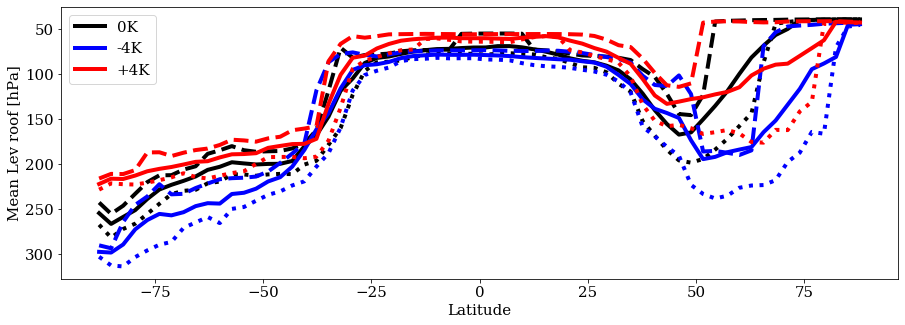

In [268]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [269]:
lev_roof_0 = data2levroof(dataref,'continuous',Tnot=0.1)
lev_roof_m4 = data2levroof(datam4K,'continuous',Tnot=0.1)
lev_roof_p4 = data2levroof(datap4K,'continuous',Tnot=0.1)

Text(0, 0.5, 'Mean Lev roof [hPa]')

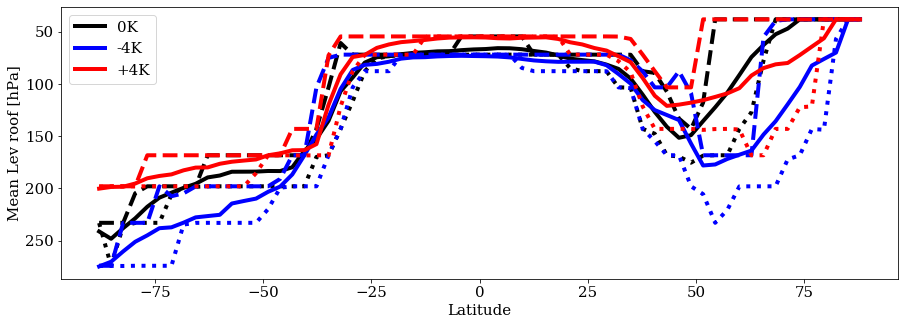

In [270]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [271]:
lev_roof_0 = data2levroof(dataref,'continuous',Tnot=1)
lev_roof_m4 = data2levroof(datam4K,'continuous',Tnot=1)
lev_roof_p4 = data2levroof(datap4K,'continuous',Tnot=1)

Text(0, 0.5, 'Mean Lev roof [hPa]')

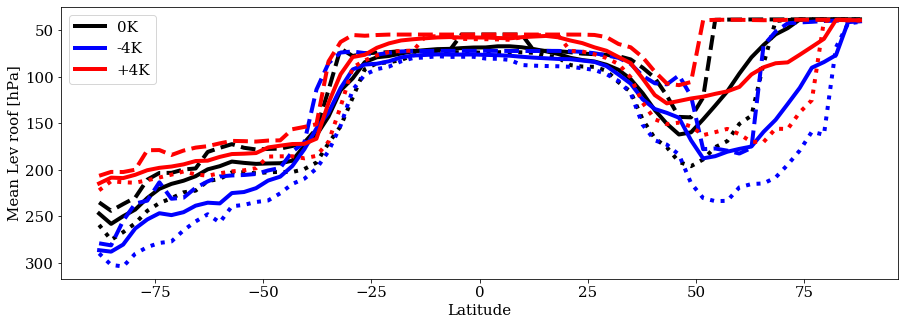

In [272]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

## Zooming on NP to find bug

In [95]:
lev_roof_m4.shape

(48, 64, 128)

In [99]:
datam4K.TAP.shape

(48, 30, 64, 128)

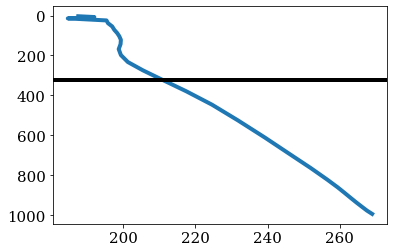

In [139]:
plt.plot(np.mean(datam4K.TAP.values[:,:,-5:,:],axis=(0,2,3)),datam4K.lev)
plt.axhline(y=np.mean(lev_roof_m4[:,-5:,:],axis=(0,1,2)),color='k')
plt.gca().invert_yaxis()

(-2, 2)

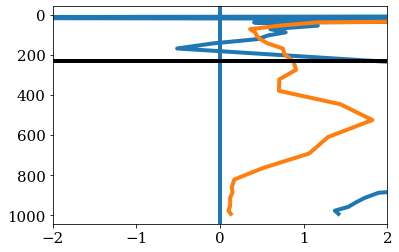

In [165]:
plt.plot(np.mean(np.diff(datam4K.TAP.values[:,:,-5:,:],axis=1),axis=(0,2,3)),datam4K.lev[1:])
plt.plot(np.std(a=np.diff(datam4K.TAP.values[:,:,-5:,:],axis=1),axis=(0,2,3)),datam4K.lev[1:])
#plt.plot(np.std(a=np.diff(datam4K.TAP.values[:,:,-5:,:],axis=1),axis=(0,2,3)),datam4K.lev[1:])
plt.axvline(x=0)
plt.axhline(y=np.mean(lev_roof_m4[:,-5:,:],axis=(0,1,2)),color='k')
plt.gca().invert_yaxis()
plt.xlim((-2,2))

In [107]:
T_NP = datam4K.TAP.values[:,:,-5:,:]

In [108]:
T_NP.shape

(48, 30, 5, 128)

In [116]:
datam4K.lev.values[np.argmin(T_NP[:,6:,:,:],axis=1)+6]

array([[[72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055]],

       [[72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01

In [119]:
datam4K.lev.values[np.argmin(T_NP[:,9:,:,:],axis=1)+9]

array([[[232.82861896, 197.9080867 , 197.9080867 , ..., 197.9080867 ,
         232.82861896, 232.82861896],
        [197.9080867 , 197.9080867 , 197.9080867 , ..., 168.22507977,
         197.9080867 , 232.82861896],
        [168.22507977, 197.9080867 , 197.9080867 , ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168.22507977, 168.22507977, ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168.22507977, 168.22507977, ..., 168.22507977,
         168.22507977, 168.22507977]],

       [[232.82861896, 197.9080867 , 197.9080867 , ..., 197.9080867 ,
         232.82861896, 232.82861896],
        [197.9080867 , 197.9080867 , 197.9080867 , ..., 168.22507977,
         197.9080867 , 232.82861896],
        [168.22507977, 197.9080867 , 197.9080867 , ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168.22507977, 168.22507977, ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168

# Test (PW,GMS) scaling for amplitude of convective heating/moistening

## Constants

In [30]:
cpair = 1.00464e3
latvap = 2.501e6
g = 9.8
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
R_D = 287 # Specific gas constant of dry air in J/K/kg

## Test on m4K first

In [31]:
QV = datam4K.QAP.values
TABS = datam4K.TAP.values
lev = datam4K.lev.values

In [32]:
# Calculate geopotential height assuming hydrostasy
S = QV.shape

r = QV/(QV**0-QV)
Tv = TABS*(r**0+r/eps)/(r**0+r)
RHO = 1e2*np.moveaxis(np.tile(lev,(S[0],S[2],S[3],1)),3,1)/(R_D*Tv)

Z = -sin.cumtrapz(x=1e2*lev,y=1/(G*RHO),axis=1)
Z = np.concatenate((np.zeros((S[0],1,S[2],S[3])),Z),axis=1)
Z = Z-np.moveaxis(np.tile(Z[:,-1,:,:],(S[1],1,1,1)),0,1)

In [33]:
# Calculate dry static energy
dse = cpair*TABS+g*Z

In [34]:
# Calculate heating to advection of moisture coefficient
HAM = -L_V*np.diff(QV,axis=1)/np.diff(dse,axis=1)
HAM = np.maximum(HAM,0)

In [35]:
HAM.shape

(48, 29, 64, 128)

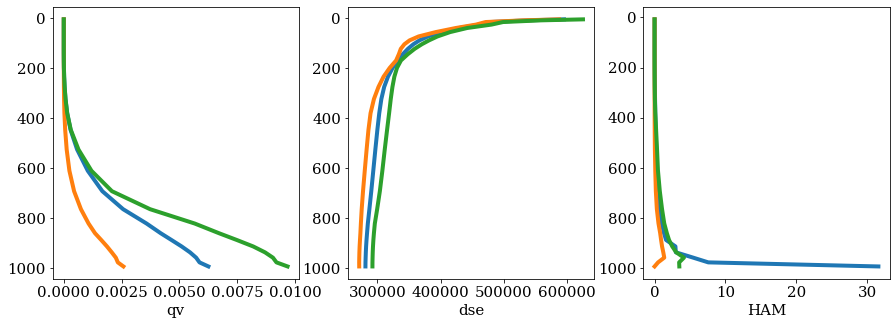

In [36]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,label in enumerate(['qv','dse','HAM']):
    if i==0: ar = QV; z = datam4K.lev.values
    elif i==1: ar = dse; z = datam4K.lev.values
    elif i==2: ar = HAM; z = datam4K.lev.values[1:]
        
    ax[i].plot(np.mean(ar[:,:,:,:],axis=(0,2,3)),z)
    ax[i].plot(np.percentile(a=ar[:,:,:,:],axis=(0,2,3),q=25),z)
    ax[i].plot(np.percentile(a=ar[:,:,:,:],axis=(0,2,3),q=75),z)
    ax[i].invert_yaxis()
    ax[i].set_xlabel(label)

In [37]:
i250 = np.argmin(np.abs(lev-250))
i500 = np.argmin(np.abs(lev-500))
i750 = np.argmin(np.abs(lev-750))

In [38]:
print(lev[i250],lev[i500],lev[i750])

232.82861895859241 524.6871747076511 763.404481112957


In [39]:
# Now calculate net conversion = -Lv*delta(q)/delta(s) and PW
NetHAMm4K = -L_V*(QV[:,i250,:,:]-QV[:,-1,:,:])/(dse[:,i250,:,:]-dse[:,-1,:,:])
ltSSm4K = (dse[:,i750,:,:]-dse[:,-1,:,:])
mtSSm4K = (dse[:,i500,:,:]-dse[:,-1,:,:])
utSSm4K = (dse[:,i250,:,:]-dse[:,-1,:,:])
PWm4K = sin.trapz(QV*dP(datam4K.PS)/G,axis=1)

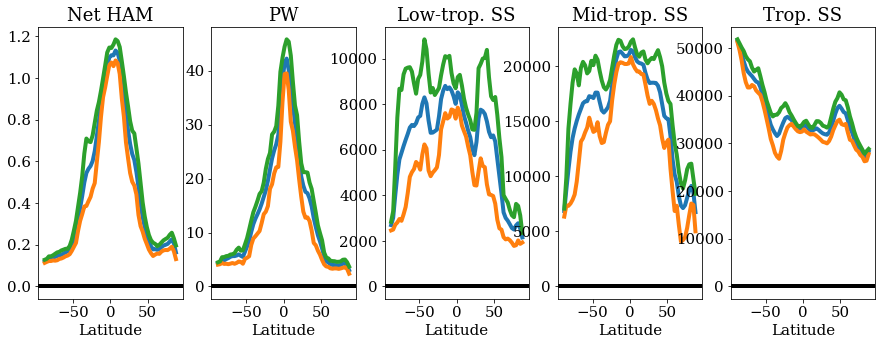

In [40]:
fig,ax = plt.subplots(1,5,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW','Low-trop. SS','Mid-trop. SS','Trop. SS']):
    if i==0: ar = NetHAMm4K
    elif i==1: ar = PWm4K
    elif i==2: ar = ltSSm4K
    elif i==3: ar = mtSSm4K
    elif i==4: ar = utSSm4K

    ax[i].plot(datam4K.lat,np.mean(ar,axis=(0,2)))
    ax[i].plot(datam4K.lat,np.percentile(a=ar,axis=(0,2),q=25))
    ax[i].plot(datam4K.lat,np.percentile(a=ar,axis=(0,2),q=75))
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Latitude')
    ax[i].set_title(label)

In [41]:
# Now calculate net convective heating and moistening within climate to see how they scale with PW/NetHAM
HEATm4K = np.sum(cpair*datam4K.TPHYSTND*dP(datam4K.PS)/g,axis=1).values
MOISTm4K = np.sum(latvap*datam4K.PHQ*dP(datam4K.PS)/g,axis=1).values

In [42]:
PWhist,PWbinedg = np.histogram(a=PWm4K,bins=100)
NetHAMhist,NetHAMbinedg = np.histogram(a=NetHAMm4K,bins=100)
LTsshist,LTssbinedg = np.histogram(a=ltSSm4K,bins=100)
MTsshist,MTssbinedg = np.histogram(a=mtSSm4K,bins=100)
UTsshist,UTssbinedg = np.histogram(a=utSSm4K,bins=100)

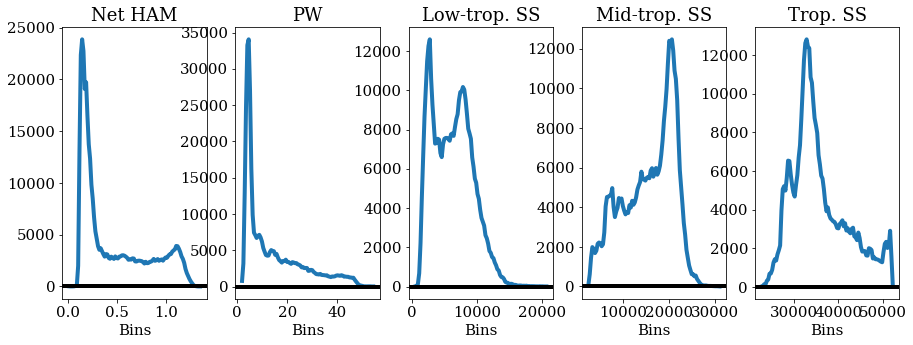

In [43]:
fig,ax = plt.subplots(1,5,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW','Low-trop. SS','Mid-trop. SS','Trop. SS']):
    if i==0: pdf = NetHAMhist; edg = NetHAMbinedg; mid = edg2bin(edg)
    elif i==1: pdf = PWhist; edg = PWbinedg; mid = edg2bin(edg)
    elif i==2: pdf = LTsshist; edg = LTssbinedg; mid = edg2bin(edg)
    elif i==3: pdf = MTsshist; edg = MTssbinedg; mid = edg2bin(edg)
    elif i==4: pdf = UTsshist; edg = UTssbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,pdf)
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [44]:
Hmean = {}
Hstd = {}
Mmean = {}
Mstd = {}

In [45]:
for i,label in enumerate(['Net HAM','PW','Low-trop. SS','Mid-trop. SS','Trop. SS']):
    if i==0: bin_edges = NetHAMbinedg; field_x = NetHAMm4K;
    elif i==1: bin_edges = PWbinedg; field_x = PWm4K;
    elif i==2: bin_edges = LTssbinedg; field_x = ltSSm4K;
    elif i==3: bin_edges = MTssbinedg; field_x = mtSSm4K;
    elif i==4: bin_edges = UTssbinedg; field_x = utSSm4K;
        
    Hmean[label],Hstd[label] = conditional_avg_and_std(bin_edges,field_x,HEATm4K)
    Mmean[label],Mstd[label] = conditional_avg_and_std(bin_edges,field_x,MOISTm4K)

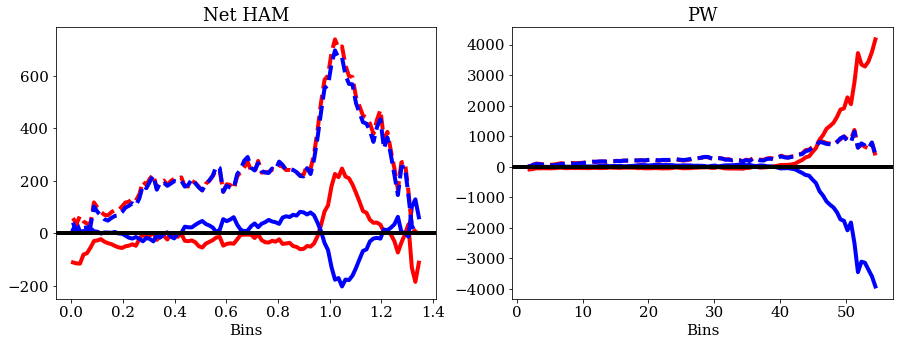

In [46]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW']):
    if i==0: pdf = NetHAMhist; edg = NetHAMbinedg; mid = edg2bin(edg); 
    elif i==1: pdf = PWhist; edg = PWbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,Hmean[label],color='r')
    ax[i].plot(mid,Mmean[label],color='b')
    ax[i].plot(mid,Hstd[label],color='r',linestyle='--')
    ax[i].plot(mid,Mstd[label],color='b',linestyle='--')
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

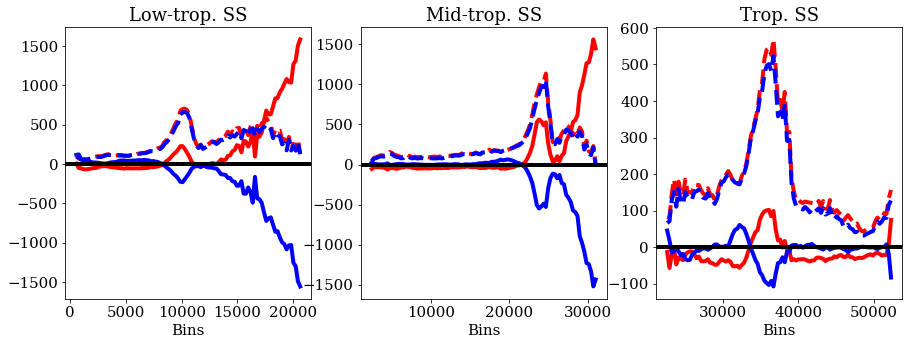

In [47]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,label in enumerate(['Low-trop. SS','Mid-trop. SS','Trop. SS']):
    
    if i==0: pdf = LTsshist; edg = LTssbinedg; mid = edg2bin(edg)
    elif i==1: pdf = MTsshist; edg = MTssbinedg; mid = edg2bin(edg)
    elif i==2: pdf = UTsshist; edg = UTssbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,Hmean[label],color='r')
    ax[i].plot(mid,Mmean[label],color='b')
    ax[i].plot(mid,Hstd[label],color='r',linestyle='--')
    ax[i].plot(mid,Mstd[label],color='b',linestyle='--')
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [48]:
# Only scale the positive convective heating and moistening
HEAThist,HEATbinedg = np.histogram(a=HEATm4K.flatten(),bins=100)
MOISThist,MOISTbinedg = np.histogram(a=MOISTm4K.flatten(),bins=100)

In [49]:
# Find percentile for which HEAT>0
HEATper = stats.percentileofscore(a=HEATm4K.flatten(),score=0)
MOISTper = stats.percentileofscore(a=MOISTm4K.flatten(),score=0)
print(HEATper,MOISTper)

71.06602986653645 33.339945475260414


In [50]:
# So let's use the 80th percentile by analogy with how we split last time
HEATp80 = np.percentile(a=HEATm4K.flatten(),q=80)

In [51]:
HEATp80

33.07332229614258

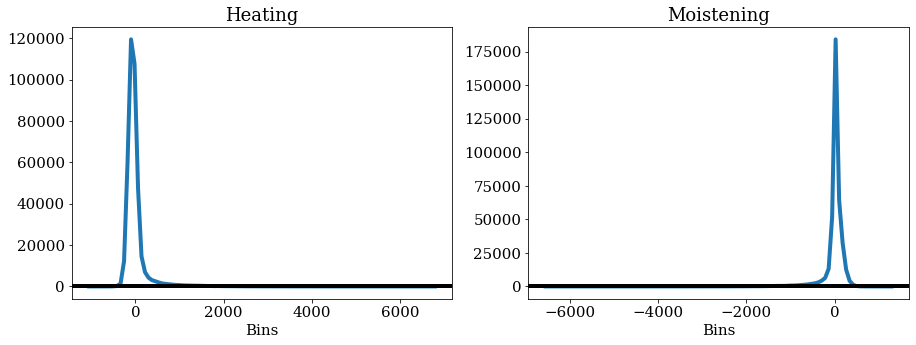

In [52]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Heating','Moistening']):
    if i==0: pdf = HEAThist; edg = HEATbinedg; mid = edg2bin(edg)
    elif i==1: pdf = MOISThist; edg = MOISTbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,pdf)
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [53]:
NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp80].shape

(78643,)

In [54]:
PWm4K.flatten().shape

(393216,)

In [55]:
X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1),
                   np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)),axis=1)

In [56]:
X.shape

(78643, 2)

In [57]:
Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)
Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X,Yheat)
print(lin_reg.intercept_,lin_reg.coef_)

[133.65159574] [[-1526.40264889    52.29920838]]


In [59]:
log_reg = LinearRegression()
log_reg.fit(np.log10(X),np.log10(Yheat))
print(log_reg.intercept_,log_reg.coef_)

[-0.03386558] [[-1.16426244  1.54444072]]


In [60]:
Yheat_linpred = lin_reg.predict(X)
Yheat_logpred = 10**log_reg.predict(np.log10(X))

Performance of both models

In [61]:
np.mean((Yheat-Yheat_linpred)**2)/np.var(Yheat)

0.6207200591216444

In [62]:
np.mean((Yheat-Yheat_logpred)**2)/np.var(Yheat)

0.9113704520506473

Compare to model using PW only

In [63]:
X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)

In [64]:
lin_reg0 = LinearRegression()
lin_reg0.fit(X0,Yheat)
print(lin_reg0.intercept_,lin_reg0.coef_)

[-21.29123] [[15.6903715]]


In [65]:
log_reg0 = LinearRegression()
log_reg0.fit(np.log10(X0),np.log10(Yheat))
print(log_reg0.intercept_,log_reg0.coef_)

[1.5235063] [[0.5517373]]


In [66]:
Yheat_linpred0 = lin_reg0.predict(X0)
Yheat_logpred0 = 10**log_reg0.predict(np.log10(X0))

In [67]:
np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)

0.76603854

In [68]:
np.mean((Yheat-Yheat_logpred0)**2)/np.var(Yheat)

0.97032505

Now how sensitive is it to the percentile we choose to isolate extreme heating events?  
And is it really worth including the GMS?

In [69]:
Perc_array = np.array([75,80,85,90])

In [70]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATm4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    
    print('**LINEAR**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWm4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWm4K regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWm4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWm4K,HAM regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 75
**LINEAR**
PWm4K regression for heating: intercept= [-38.47345] Coefficient= [[14.865585]] error= 76.8 % of variance


PWm4K regression for moistening: intercept= [69.79469] Coefficient= [[-12.896812]] error= 83.0 % of variance


(PWm4K,HAM) regression for heating: intercept= [95.74436171] Coefficient= [[-1414.43368171    49.70410179]] 
 error= 61.8 % of variance


PWm4K,HAM regression for moistening: intercept= [-84.19893209] Coefficient= [[1622.83889594  -52.8685023 ]] 
 error= 63.9 % of variance


perc= 80
**LINEAR**
PWm4K regression for heating: intercept= [-21.29123] Coefficient= [[15.6903715]] error= 76.6 % of variance


PWm4K regression for moistening: intercept= [59.11537] Coefficient= [[-13.997761]] error= 81.9 % of variance


(PWm4K,HAM) regression for heating: intercept= [133.65159574] Coefficient= [[-1526.40264889    52.29920838]] 
 error= 62.1 % of variance


PWm4K,HAM regression for moistening: intercept= [-115.50936987] Coefficient= [[1720.29680072  -55.256902

In [71]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATm4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWm4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWm4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 75
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.2958121] Coefficient= [[0.62395406]] error= 98.5 % of variance


(PWm4K,HAM) regression for heating: intercept= [-0.33761425] Coefficient= [[-1.20574318  1.67257896]] 
 error= 92.9 % of variance


perc= 80
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.5235063] Coefficient= [[0.5517373]] error= 97.0 % of variance


(PWm4K,HAM) regression for heating: intercept= [-0.03386558] Coefficient= [[-1.16426244  1.54444072]] 
 error= 91.1 % of variance


perc= 85
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.726861] Coefficient= [[0.5085051]] error= 94.6 % of variance


(PWm4K,HAM) regression for heating: intercept= [0.39327412] Coefficient= [[-1.00795664  1.35063835]] 
 error= 89.2 % of variance


perc= 90
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.9887826] Coefficient= [[0.44254896]] error= 92.5 % of variance


(PWm4K,HAM) regression for heating: intercept= [0.72775735] Coefficien

Now test which one is most predictive among lower-tropospheric, mid-tropospheric and upper-tropospheric static stability

In [72]:
Perc_array = np.array([80,90])

In [73]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATm4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    XL = np.concatenate((np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(ltSSm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    XM = np.concatenate((np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(mtSSm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    XU = np.concatenate((np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(utSSm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWm4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWm4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XL),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XL))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(LTm4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XM),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XM))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(MTm4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XU),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XU))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(UTm4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 80
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.5235063] Coefficient= [[0.5517373]] error= 97.0 % of variance


(PWm4K,HAM) regression for heating: intercept= [-0.03386558] Coefficient= [[-1.16426244  1.54444072]] 
 error= 91.1 % of variance


(LTm4K,PW) regression for heating: intercept= [1.41896248] Coefficient= [[0.5392724  0.03124925]] 
 error= 97.0 % of variance




(MTm4K,PW) regression for heating: intercept= [3.63750029] Coefficient= [[ 0.75788688 -0.5594154 ]] 
 error= 96.3 % of variance


(UTm4K,PW) regression for heating: intercept= [0.20273958] Coefficient= [[0.56516937 0.28742812]] 
 error= 96.5 % of variance


perc= 90
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.9887826] Coefficient= [[0.44254896]] error= 92.5 % of variance


(PWm4K,HAM) regression for heating: intercept= [0.72775735] Coefficient= [[-0.96969394  1.23086124]] 
 error= 87.1 % of variance


(LTm4K,PW) regression for heating: intercept= [1.0252398] Coefficient= [[0.32087

## Repeat test for p4K

In [74]:
QV = datap4K.QAP.values
TABS = datap4K.TAP.values
lev = datap4K.lev.values

In [75]:
# Calculate geopotential height assuming hydrostasy
S = QV.shape

r = QV/(QV**0-QV)
Tv = TABS*(r**0+r/eps)/(r**0+r)
RHO = 1e2*np.moveaxis(np.tile(lev,(S[0],S[2],S[3],1)),3,1)/(R_D*Tv)

Z = -sin.cumtrapz(x=1e2*lev,y=1/(G*RHO),axis=1)
Z = np.concatenate((np.zeros((S[0],1,S[2],S[3])),Z),axis=1)
Z = Z-np.moveaxis(np.tile(Z[:,-1,:,:],(S[1],1,1,1)),0,1)

In [76]:
# Now calculate net conversion = -Lv*delta(q)/delta(s) and PW
NetHAMp4K = -L_V*(QV[:,i250,:,:]-QV[:,-1,:,:])/(dse[:,i250,:,:]-dse[:,-1,:,:])
PWp4K = sin.trapz(QV*dP(datam4K.PS)/G,axis=1)
ltSSp4K = (dse[:,i750,:,:]-dse[:,-1,:,:])
mtSSp4K = (dse[:,i500,:,:]-dse[:,-1,:,:])
utSSp4K = (dse[:,i250,:,:]-dse[:,-1,:,:])

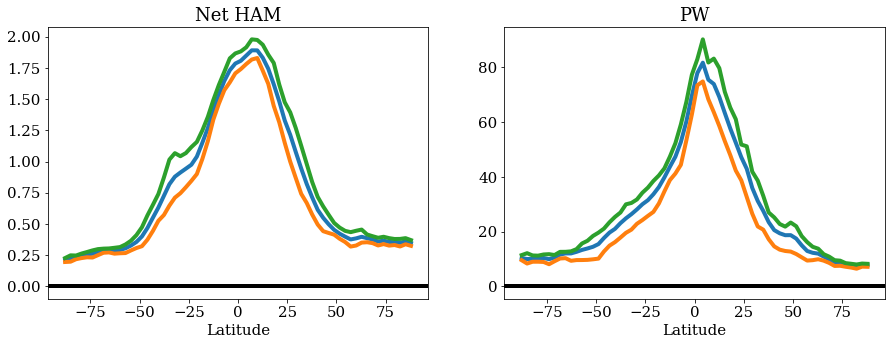

In [77]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW']):
    if i==0: ar = NetHAMp4K
    elif i==1: ar = PWp4K

    ax[i].plot(datap4K.lat,np.mean(ar,axis=(0,2)))
    ax[i].plot(datap4K.lat,np.percentile(a=ar,axis=(0,2),q=25))
    ax[i].plot(datap4K.lat,np.percentile(a=ar,axis=(0,2),q=75))
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Latitude')
    ax[i].set_title(label)

In [78]:
# Now calculate net convective heating and moistening within climate to see how they scale with PW/NetHAM
HEATp4K = np.sum(cpair*datap4K.TPHYSTND*dP(datap4K.PS)/g,axis=1).values
MOISTp4K = np.sum(latvap*datap4K.PHQ*dP(datap4K.PS)/g,axis=1).values

In [79]:
PWhist,PWbinedg = np.histogram(a=PWp4K,bins=100)
NetHAMhist,NetHAMbinedg = np.histogram(a=NetHAMp4K,bins=100)

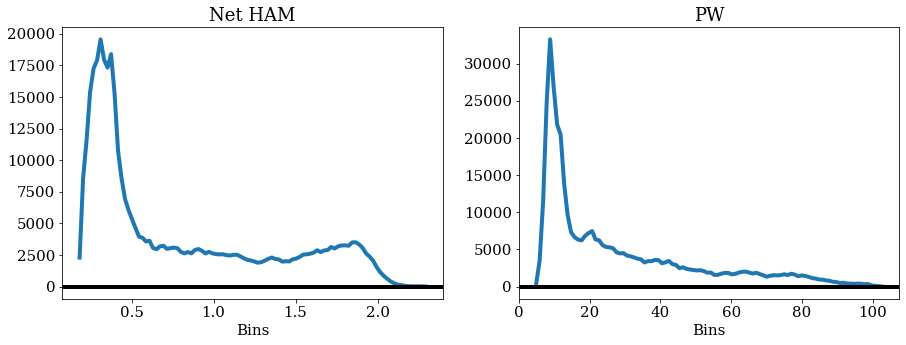

In [80]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW']):
    if i==0: pdf = NetHAMhist; edg = NetHAMbinedg; mid = edg2bin(edg)
    elif i==1: pdf = PWhist; edg = PWbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,pdf)
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [81]:
Perc_array = np.array([75,80,85,90])

In [82]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATp4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    
    print('**LINEAR**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWp4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWp4K regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWp4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWp4K,HAM regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')




perc= 75
**LINEAR**
PWp4K regression for heating: intercept= [-59.424255] Coefficient= [[10.672213]] error= 80.7 % of variance


PWp4K regression for moistening: intercept= [86.95604] Coefficient= [[-9.7544565]] error= 84.6 % of variance


(PWp4K,HAM) regression for heating: intercept= [93.66904116] Coefficient= [[-1103.07343656    34.45490194]] 
 error= 68.1 % of variance


PWp4K,HAM regression for moistening: intercept= [-92.89056665] Coefficient= [[1295.83818007  -37.69323221]] 
 error= 67.9 % of variance


perc= 80
**LINEAR**
PWp4K regression for heating: intercept= [-44.84543] Coefficient= [[11.751002]] error= 78.9 % of variance


PWp4K regression for moistening: intercept= [74.91995] Coefficient= [[-11.00517]] error= 82.2 % of variance


(PWp4K,HAM) regression for heating: intercept= [124.48530244] Coefficient= [[-1193.97708117    36.89618542]] 
 error= 66.9 % of variance


PWp4K,HAM regression for moistening: intercept= [-120.71362099] Coefficient= [[1379.44292365  -40.0562693

In [83]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATp4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWp4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWp4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 75
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.309974] Coefficient= [[0.52574486]] error= 101.7 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.12801438] Coefficient= [[-0.85516344  1.26573635]] 
 error= 99.4 % of variance


perc= 80
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.497917] Coefficient= [[0.51023144]] error= 99.0 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.56864996] Coefficient= [[-0.68489964  1.08848777]] 
 error= 97.0 % of variance


perc= 85
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.6938229] Coefficient= [[0.48571277]] error= 96.5 % of variance


(PWp4K,HAM) regression for heating: intercept= [1.03077263] Coefficient= [[-0.49848153  0.8953818 ]] 
 error= 95.0 % of variance


perc= 90
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.9251246] Coefficient= [[0.45396402]] error= 93.3 % of variance


(PWp4K,HAM) regression for heating: intercept= [1.48605704] Coefficien

In [84]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATp4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    XL = np.concatenate((np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(ltSSp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    XM = np.concatenate((np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(mtSSp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    XU = np.concatenate((np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(utSSp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWp4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWp4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XL),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XL))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(LTp4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XM),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XM))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(MTp4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XU),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XU))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(UTp4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')




perc= 75
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.309974] Coefficient= [[0.52574486]] error= 101.7 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.12801438] Coefficient= [[-0.85516344  1.26573635]] 
 error= 99.4 % of variance


(LTp4K,PW) regression for heating: intercept= [2.68350595] Coefficient= [[ 0.66158143 -0.41487661]] 
 error= 100.5 % of variance




(MTp4K,PW) regression for heating: intercept= [3.62099107] Coefficient= [[ 0.7300201  -0.62088874]] 
 error= 100.2 % of variance


(UTp4K,PW) regression for heating: intercept= [4.44145757] Coefficient= [[ 0.48927251 -0.67751998]] 
 error= 101.7 % of variance


perc= 80
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.497917] Coefficient= [[0.51023144]] error= 99.0 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.56864996] Coefficient= [[-0.68489964  1.08848777]] 
 error= 97.0 % of variance


(LTp4K,PW) regression for heating: intercept= [2.64125111] Coefficient= [[

## Compare candidate rescalings in both regimes

Candidate 1 = sqrt(PW)

In [85]:
Hp80m = np.percentile(a=HEATm4K.flatten(),q=80)
Hp80p = np.percentile(a=HEATp4K.flatten(),q=80)

In [125]:
Hsc1m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc1p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc1m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]/(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Msc1p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]/(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

In [126]:
Hsc2m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**1/\
(NetHAMm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc2p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**1/\
(NetHAMp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc2m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]/(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**1*\
(NetHAMm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Msc2p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]/(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**1*\
(NetHAMp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

In [127]:
Hsc3m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5/\
(mtSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc3p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5/\
(mtSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc3m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]/(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5*\
(mtSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Msc3p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]/(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5*\
(mtSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

In [128]:
Hsc4m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5*\
(utSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc4p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5*\
(utSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc4m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**(-0.5)*\
(utSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**(-0.5)
Msc4p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**(-0.5)*\
(utSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**(-0.5)

In [129]:
Hnoscm4KH = np.histogram(HEATm4K.flatten()[HEATm4K.flatten()>Hp80m],bins=100)
Hnoscp4KH = np.histogram(HEATp4K.flatten()[HEATp4K.flatten()>Hp80m],bins=100)
Mnoscm4KH = np.histogram(MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m],bins=100)
Mnoscp4KH = np.histogram(MOISTp4K.flatten()[HEATp4K.flatten()>Hp80m],bins=100)

Hsc1m4KH = np.histogram(Hsc1m4K,bins=100)
Hsc1p4KH = np.histogram(Hsc1p4K,bins=100)
Msc1m4KH = np.histogram(Msc1m4K,bins=100)
Msc1p4KH = np.histogram(Msc1p4K,bins=100)

Hsc2m4KH = np.histogram(Hsc2m4K,bins=100)
Hsc2p4KH = np.histogram(Hsc2p4K,bins=100)
Msc2m4KH = np.histogram(Msc2m4K,bins=100)
Msc2p4KH = np.histogram(Msc2p4K,bins=100)

Hsc3m4KH = np.histogram(Hsc3m4K,bins=100)
Hsc3p4KH = np.histogram(Hsc3p4K,bins=100)
Msc3m4KH = np.histogram(Msc3m4K,bins=100)
Msc3p4KH = np.histogram(Msc3p4K,bins=100)

Hsc4m4KH = np.histogram(Hsc4m4K,bins=100)
Hsc4p4KH = np.histogram(Hsc4p4K,bins=100)
Msc4m4KH = np.histogram(Msc4m4K,bins=100)
Msc4p4KH = np.histogram(Msc4p4K,bins=100)

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log1

Text(0.5, 0, '$\\dot{T}\\ \\sqrt{\\mathrm{PW}/(\\mathrm{DSE}_{500}-\\mathrm{DSE}_{NS})}$')

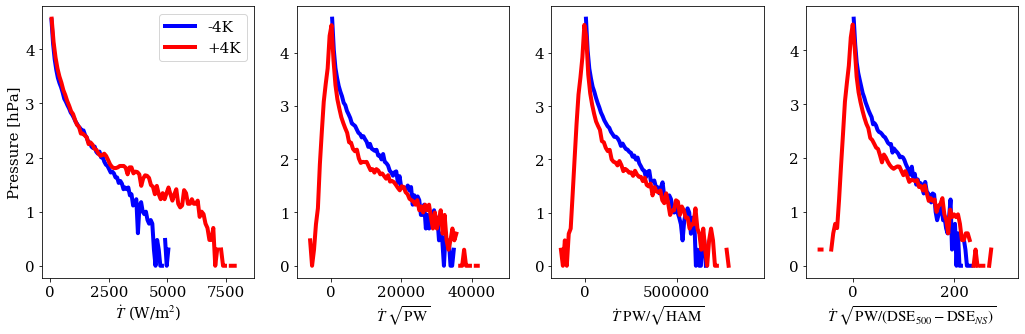

In [130]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))

ax[0].plot(edg2bin(Hnoscm4KH[1]),np.log10(Hnoscm4KH[0]),color='b',label='-4K')
ax[0].plot(edg2bin(Hnoscp4KH[1]),np.log10(Hnoscp4KH[0]),color='r',label='+4K')
ax[0].legend()
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$\dot{T}$ (W/m$^2$)')

ax[1].plot(edg2bin(Hsc1m4KH[1]),np.log10(Hsc1m4KH[0]),color='b')
ax[1].plot(edg2bin(Hsc1p4KH[1]),np.log10(Hsc1p4KH[0]),color='r')
ax[1].set_xlabel('$\dot{T}\ \sqrt{\mathrm{PW}}$')

# ax[2].plot(edg2bin(Hsc2m4KH[1]),np.log10(Hsc2m4KH[0]),color='b')
# ax[2].plot(edg2bin(Hsc2p4KH[1]),np.log10(Hsc2p4KH[0]),color='r')
# ax[2].set_xlabel('$\dot{T}\ \mathrm{PW}/\sqrt{\mathrm{HAM}}$')
ax[2].plot(edg2bin(Hsc4m4KH[1]),np.log10(Hsc4m4KH[0]),color='b')
ax[2].plot(edg2bin(Hsc4p4KH[1]),np.log10(Hsc4p4KH[0]),color='r')
ax[2].set_xlabel('$\dot{T}\ \mathrm{PW}/\sqrt{\mathrm{HAM}}$')

ax[3].plot(edg2bin(Hsc3m4KH[1]),np.log10(Hsc3m4KH[0]),color='b')
ax[3].plot(edg2bin(Hsc3p4KH[1]),np.log10(Hsc3p4KH[0]),color='r')
ax[3].set_xlabel('$\dot{T}\ \sqrt{\mathrm{PW}/(\mathrm{DSE}_{500}-\mathrm{DSE}_{NS})}$')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log1

Text(0.5, 0, '$\\dot{q}\\ \\sqrt{(\\mathrm{DSE}_{500}-\\mathrm{DSE}_{NS})/\\mathrm{PW}}$')

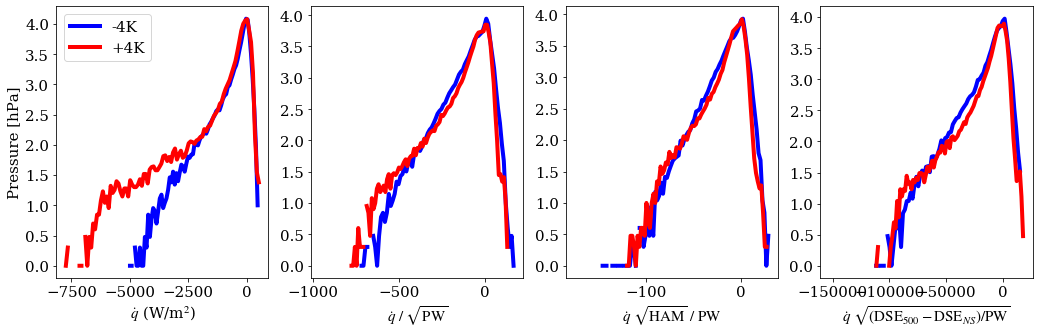

In [131]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))

ax[0].plot(edg2bin(Mnoscm4KH[1]),np.log10(Mnoscm4KH[0]),color='b',label='-4K')
ax[0].plot(edg2bin(Mnoscp4KH[1]),np.log10(Mnoscp4KH[0]),color='r',label='+4K')
ax[0].legend()
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$\dot{q}$ (W/m$^2$)')

ax[1].plot(edg2bin(Msc1m4KH[1]),np.log10(Msc1m4KH[0]),color='b')
ax[1].plot(edg2bin(Msc1p4KH[1]),np.log10(Msc1p4KH[0]),color='r')
ax[1].set_xlabel('$\dot{q}\ /\ \sqrt{\mathrm{PW}}$')

ax[2].plot(edg2bin(Msc2m4KH[1]),np.log10(Msc2m4KH[0]),color='b')
ax[2].plot(edg2bin(Msc2p4KH[1]),np.log10(Msc2p4KH[0]),color='r')
ax[2].set_xlabel('$\dot{q}\ \sqrt{\mathrm{HAM}}\ /\ \mathrm{PW}$')
# ax[2].plot(edg2bin(Msc4m4KH[1]),np.log10(Msc4m4KH[0]),color='b')
# ax[2].plot(edg2bin(Msc4p4KH[1]),np.log10(Msc4p4KH[0]),color='r')
# ax[2].set_xlabel('$\dot{T}\ \mathrm{PW}/\sqrt{\mathrm{HAM}}$')

ax[3].plot(edg2bin(Msc3m4KH[1]),np.log10(Msc3m4KH[0]),color='b')
ax[3].plot(edg2bin(Msc3p4KH[1]),np.log10(Msc3p4KH[0]),color='r')
ax[3].set_xlabel('$\dot{q}\ \sqrt{(\mathrm{DSE}_{500}-\mathrm{DSE}_{NS})/\mathrm{PW}}$')